### PyTorch Neural Network Classification

Regression gives you a numerical prediction

Classification gives you an output classifying if something is X Y or Z, X or Y, Spam or not Spam. **CAT or DOG**

Images are typically represented as Batch Size, Color Channels, Width, Height

`Shape = [32, 3, 224, 224]`

Batch size - looks at 32 images at a time

The **Book Version** of this course has a nice chart regarding hyperparameters and classifications types: **Binary and Multiclass**

Pytorch creates the neural network layers in the background, each layer and node performs a math operation.

Models can be setup with many sequences of neural networks with in features and out features that feed each other.

### Make a Toy Classification Dataset

We will need sklearn

`pip install scikit-learn`

In [1]:
import torch
from torch import nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path

torch.__version__

# Random seed number
RANDOM_SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch is using: {device}")

Torch is using: cpu


In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make a DataFrame of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                      "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


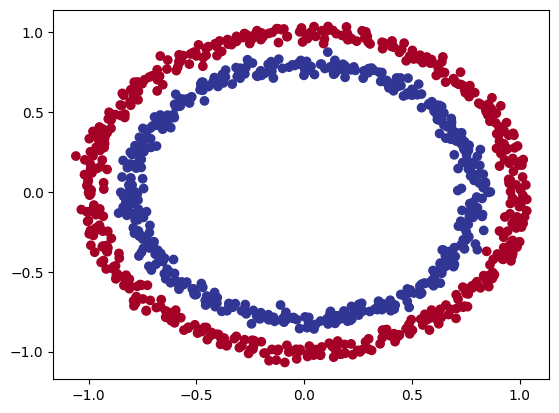

In [6]:
# Visualize the data
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

**NOTE:** This is toy dataset, small enough to work on but large enough to play around with and visualize.

#### scikit-learn.org has a large number of toy datasets to play with.

### Turn data into tensors and make Train/Test Split

### Check Input and Output Shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first exmaple of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

# Video 72 3:35 

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Check the datatypes
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
# Scikit learn has methods to do Train/Test split on data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% test, 80% train
                                                    random_state = 42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [13]:
n_samples

1000

### Building a model

* Classify our red and blue dots
* 1. Device agostic code
  2. Build a model via class constructor/sub class nn.module
  3. Define a loss func and optimizer
  4. Create a train/test loop



In [14]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [15]:
# Subclass nn.module
# create 2 nn.Linear() layers that can handle the shape of our data
# Define a forward() method
# Instantiate an instance of the model class and send it to target device

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create layers that handle our shapes
        self.layer_1 = nn.Linear(in_features = 2, out_features = 8) # takes in 2, upscales to 8
        self.layer_2 = nn.Linear(in_features = 8, out_features = 16)
        self.layer_3 = nn.Linear(in_features = 16, out_features = 8)
        self.layer_4 = nn.Linear(in_features = 8, out_features = 1) # takes in 8, outputs 1

    # Forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))) # x -> layer 1 -> layer 2

# Instantiate to device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_4): Linear(in_features=8, out_features=1, bias=True)
)

In [16]:
device

'cpu'

In [17]:
next(model_0.parameters()).device # Check to see if model params are on the correct device

device(type='cpu')

### Create Model Fast Using `nn.Sequential`

If you just need a simple seq model this is much simpler to build, the sub class method allows for more customization

You could add this sequential nn to the class if you wanted.

In [18]:
# We can create a similar model with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 8),
    #nn.Linear(in_features = 8, out_features = 128),
    #nn.ReLU(),
    #nn.Linear(in_features = 128, out_features = 128),
    #nn.ReLU(),
    #nn.Linear(in_features = 128, out_features = 32),
    #nn.Linear(in_features = 32, out_features = 8),
    nn.Linear(in_features = 8, out_features = 1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2209, -0.2480],
                      [ 0.0109, -0.3078],
                      [ 0.6403, -0.0011],
                      [-0.2438, -0.0630],
                      [ 0.1596,  0.4950],
                      [ 0.4581,  0.5622],
                      [-0.2340,  0.1804],
                      [-0.6886,  0.1579]])),
             ('0.bias',
              tensor([ 0.4676, -0.5727, -0.2827, -0.6503,  0.3054, -0.1592,  0.1671, -0.3721])),
             ('1.weight',
              tensor([[ 0.0704,  0.0041, -0.0886,  0.2775, -0.1350, -0.1412,  0.1867, -0.1352]])),
             ('1.bias', tensor([0.3089]))])

In [20]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device)) # pass test data to model/device
print(f"Len of preds: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Len of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 Preds: {untrained_preds[:10]}")
print(f"\nFirst 10 Labels: {y_test[:10]}")

Len of preds: 200, Shape: torch.Size([200, 1])
Len of test samples: 200, Shape: torch.Size([200, 2])

First 10 Preds: tensor([[0.1971],
        [0.0810],
        [0.4245],
        [0.1330],
        [0.3021],
        [0.2321],
        [0.0021],
        [0.0372],
        [0.4293],
        [0.0718]])

First 10 Labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Loss Function and Optimizer

We need to pick a loss function and optimizer that matches the use case of classification, no regression.

* Regression
* * MAE or MSE
* Classification
* * Binary Cross Entropy or Categorical Cross Entropy
 
* Logit
* * Deep learning definition
  * * Layer that feeds softmax, helps produce a 0 or 1 output
    * SDG and Adam are popular Logit Optimizers

We will focus on `torch.nn.BCEWithLogitsLoss()`

In [21]:
# Loss function (B C E, Binary Cross Entropy)
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in, this is the numerical stable way

# Optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.001)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2209, -0.2480],
                      [ 0.0109, -0.3078],
                      [ 0.6403, -0.0011],
                      [-0.2438, -0.0630],
                      [ 0.1596,  0.4950],
                      [ 0.4581,  0.5622],
                      [-0.2340,  0.1804],
                      [-0.6886,  0.1579]])),
             ('0.bias',
              tensor([ 0.4676, -0.5727, -0.2827, -0.6503,  0.3054, -0.1592,  0.1671, -0.3721])),
             ('1.weight',
              tensor([[ 0.0704,  0.0041, -0.0886,  0.2775, -0.1350, -0.1412,  0.1867, -0.1352]])),
             ('1.bias', tensor([0.3089]))])

In [23]:
# Calculate accuracy out of 100 examples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item gets the value out as a single item, this also moves it to cpu
    acc = (correct / len(y_pred)) * 100
    return acc

### Train the Model

* Build a training loop
* * 1. Forward Pass
  * 2. Calc the loss
  * 3. Optimizer zero gradient
  * 4. Backpropagation
  * 5. Optimizer step (gradient descent)


### Go from Raw Logits to Predictions Probabilities to Prediction Labels

* Outputs of our model are raw **Logits**
* Convert **Logits** into pred probailities by passing them through an activation function
* * Sigmoid for binary classification
  * Softmax for multiclass classification

Conver the models prediction probabilities to **prediction labels** by rounding them or taking the argmax()

In [24]:
# View first 5 outputs of the forweard pass on the test data
model_0.eval() # Use training mode when making predictions
with torch.inference_mode(): # Use inference mode when making predictions
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1971],
        [0.0810],
        [0.4245],
        [0.1330],
        [0.3021]])

In [25]:
y_test[:5] # Note the logits are not in the same format as the test labels

tensor([1., 0., 1., 0., 1.])

### Use sigmoid activation function to turn logits into prediction probabilities

In [26]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5491],
        [0.5202],
        [0.6046],
        [0.5332],
        [0.5750]])

### Now that the above `y_pred_probs` have been passed through sigmoid activation function

### We can pass to torch.round function to compare to test labels

`y_pred_probs` >= 0.5 = 1, < 0.5 = 0

In [27]:
torch.round(y_pred_probs), y_test.to(device)[:5]

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([1., 0., 1., 0., 1.]))

In [28]:
##### Find the predicted labels
# We got raw logits, then turned them into pred probs, now we need pred labels
y_preds = torch.round(y_pred_probs) # predicted labels

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### Build a Training and Test Loop

In [29]:
# Seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epoochs
epochs = 5000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building and eval loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward Pass
    y_logits = model_0(X_train).squeeze() # pass raw logits
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calc loss and accuracy
    loss = loss_fn(y_logits, # Because we are using BCEWithLogits, it expects logits as input
                   y_train)
    # If we were writing loss with BCELoss without logits
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # creates pred prob from logits
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # Optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Testing forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Testing Calc loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")



Epoch: 0 | Loss: 0.70523 | Acc: 50.62% | Test Loss: 0.69781 | Test Acc: 50.50% | Device: cpu
Epoch: 500 | Loss: 0.70122 | Acc: 58.38% | Test Loss: 0.69450 | Test Acc: 60.00% | Device: cpu
Epoch: 1000 | Loss: 0.69885 | Acc: 54.25% | Test Loss: 0.69274 | Test Acc: 53.50% | Device: cpu
Epoch: 1500 | Loss: 0.69739 | Acc: 52.75% | Test Loss: 0.69181 | Test Acc: 53.50% | Device: cpu
Epoch: 2000 | Loss: 0.69645 | Acc: 51.38% | Test Loss: 0.69136 | Test Acc: 52.50% | Device: cpu
Epoch: 2500 | Loss: 0.69581 | Acc: 51.00% | Test Loss: 0.69115 | Test Acc: 52.00% | Device: cpu
Epoch: 3000 | Loss: 0.69535 | Acc: 51.25% | Test Loss: 0.69108 | Test Acc: 53.00% | Device: cpu
Epoch: 3500 | Loss: 0.69500 | Acc: 50.50% | Test Loss: 0.69110 | Test Acc: 53.50% | Device: cpu
Epoch: 4000 | Loss: 0.69472 | Acc: 49.88% | Test Loss: 0.69116 | Test Acc: 53.00% | Device: cpu
Epoch: 4500 | Loss: 0.69449 | Acc: 49.75% | Test Loss: 0.69124 | Test Acc: 53.50% | Device: cpu


### Visualize the data, Its not increasing accuracy

* The model isnt learning much if any
* Visualize the data
* We can use: `plot_decision_boundary()` to get a better understanding, this is a function from the authors github

In [30]:
# Download helper func from learn pytorch repo if its not downlaoded
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Then import the file
from helper_functions import plot_predictions, plot_decision_boundary

File exists, skipping download


ModuleNotFoundError: No module named 'torchvision'

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### The model is just cutting the data straight through the middle, linear line

### Improving a Model (From a model perspective)

* Add more layers
* * More chances to learn, more connections
* Add more hidden units
* * Go from 8 hidden units to 32 hidden units, more data representation
* Run the training longer
* * Maybe we need 10000 epochs
* Change the activation functions
* Change the learning rate
* Change the loss function

We should start with hidden layers and train longer

### Use `torch.utils.tensorboard` to monitor experiments

### nn.ReLU() adds non linearity into a neural network

You can pepper these into the hidden layers and this helps resolving the issue for this specific model

### These are all options from the models perspective and not the datas perspective

These are all **Hyperparameters**
* If an engineer can change it, its a hyperparam

### Lets create a new model/class

Typically you would just change 1 value at a time which is called `Experiment Tracking`

### Build out a complete model and loop here, then visualize

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 16)
        self.layer_2 = nn.Linear(in_features = 16, out_features = 64)
        self.layer_3 = nn.ReLU()
        self.layer_4 = nn.Linear(in_features = 64, out_features = 64)
        self.layer_5 = nn.ReLU()
        self.layer_6 = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, x):
        return self.layer_6(self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))) # this is a fast way to accomplish passing data through layers

model_1 = CircleModelV1().to(device)

# Loss function (B C E, Binary Cross Entropy)
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in, this is the numerical stable way

# Optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

model_1.eval() # Use training mode when making predictions
with torch.inference_mode(): # Use inference mode when making predictions
    y_logits = model_1(X_test.to(device))[:5]
y_pred_probs = torch.sigmoid(y_logits)



# We got raw logits, then turned them into pred probs, now we need pred labels
y_preds = torch.round(y_pred_probs) # predicted labels
# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()






# Seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epoochs
epochs = 6000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building and eval loop
for epoch in range(epochs):
    # Training
    model_1.train()

    # Forward Pass
    y_logits = model_1(X_train).squeeze() # pass raw logits
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calc loss and accuracy
    loss = loss_fn(y_logits, # Because we are using BCEWithLogits, it expects logits as input
                   y_train)
    # If we were writing loss with BCELoss without logits
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # creates pred prob from logits
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # Optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # Testing forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Testing Calc loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")



# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

- Moved Jupyter-Lab to VS Code via remote backend to Lenovo P520

- Now I am executing the code on the Lenovo P520 via VS Code via my main daily box. 

- This allows easy git control from this box and the ability to run code on the Lenovo P520/Titan Xp's and RTX 3090FE

- I was running Jupyter-Lab via the web which works fine, but having everything single homed back on VSCode with all the extensions and things like CoPilot is a better experience


### Creating a Stright Line Dataset to See if Our Model is Learning Anything

I already solved this problem with ReLU's but will continue with the section as its written

In [ ]:
import torch
from torch import nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path

torch.__version__

# Random seed number
RANDOM_SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch is using: {device}")

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Same architecture as model_1 but using nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features=16),
    nn.Linear(in_features = 16, out_features=1)).to(device)

# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.0001)

# Train the model
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epochs
epochs = 240

# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f} | Device: {device}")

# Turn on eval mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot the data
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu()
                 )

### Non Linear Activations and Non-Linearity


So far we have been checking most all Linear data, we need to look at non-linear data and functions

Neural networks are mostly a combination of Linear and Non-Linear functions/lines

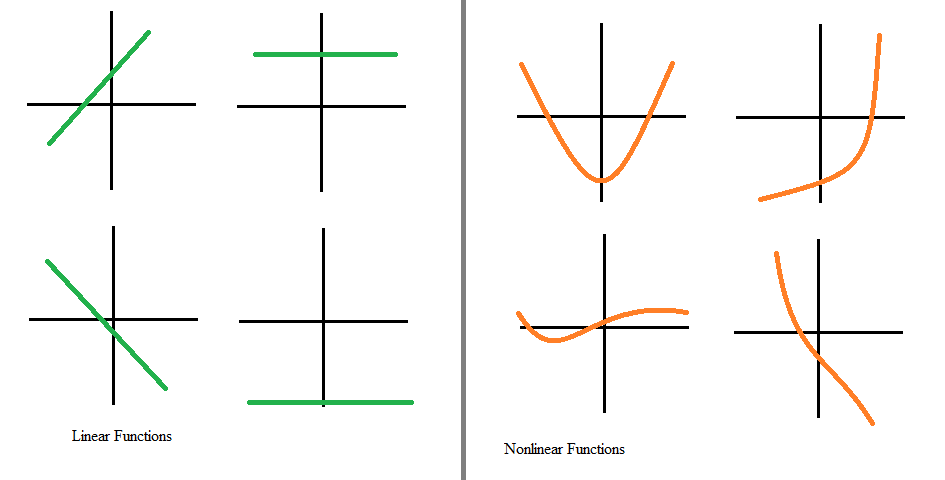

Even during something like image based food classification the network would draw lines through the image finding patterns so it can understand what is a pizza vs a sushi roll. 

### The Missing Piece: Non-Linearity

What patterns would you draw if you had infinite straight and non-straight lines

Machine learning is functionaly infinite when it comes to drawing lines through patterns

### Hidden layers are also functions

Activation functions and other things you want to do to manipulate data like Sigmoid's or ReLU are simply just another layer.

### Recreating Non-Linear Data (Red and Blue...again)

Torch is using: cuda
Epoch: 0 | Loss: 0.69338 | Acc: 47.00% | Test Loss: 0.69383 | Test Acc: 47.80% | Device: cuda
Epoch: 500 | Loss: 0.69028 | Acc: 50.72% | Test Loss: 0.69073 | Test Acc: 47.70% | Device: cuda
Epoch: 1000 | Loss: 0.66975 | Acc: 59.52% | Test Loss: 0.66832 | Test Acc: 58.60% | Device: cuda
Epoch: 1500 | Loss: 0.45176 | Acc: 72.58% | Test Loss: 0.50305 | Test Acc: 65.50% | Device: cuda
Epoch: 2000 | Loss: 0.02898 | Acc: 99.75% | Test Loss: 0.02823 | Test Acc: 100.00% | Device: cuda
Epoch: 2500 | Loss: 0.00966 | Acc: 99.88% | Test Loss: 0.00778 | Test Acc: 100.00% | Device: cuda
Epoch: 3000 | Loss: 0.00579 | Acc: 100.00% | Test Loss: 0.00463 | Test Acc: 100.00% | Device: cuda
Epoch: 3500 | Loss: 0.00403 | Acc: 100.00% | Test Loss: 0.00345 | Test Acc: 100.00% | Device: cuda
Epoch: 4000 | Loss: 0.00315 | Acc: 100.00% | Test Loss: 0.00288 | Test Acc: 100.00% | Device: cuda
Epoch: 4500 | Loss: 0.00261 | Acc: 100.00% | Test Loss: 0.00254 | Test Acc: 100.00% | Device: cuda
Fil

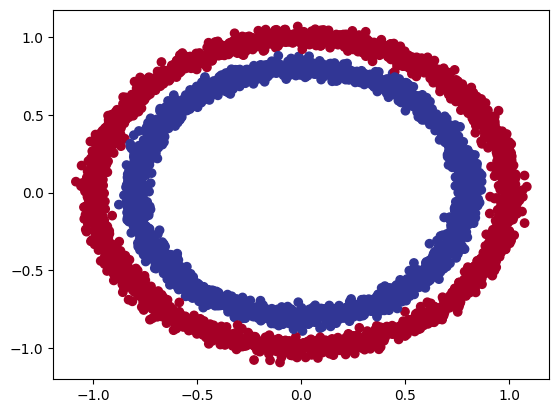

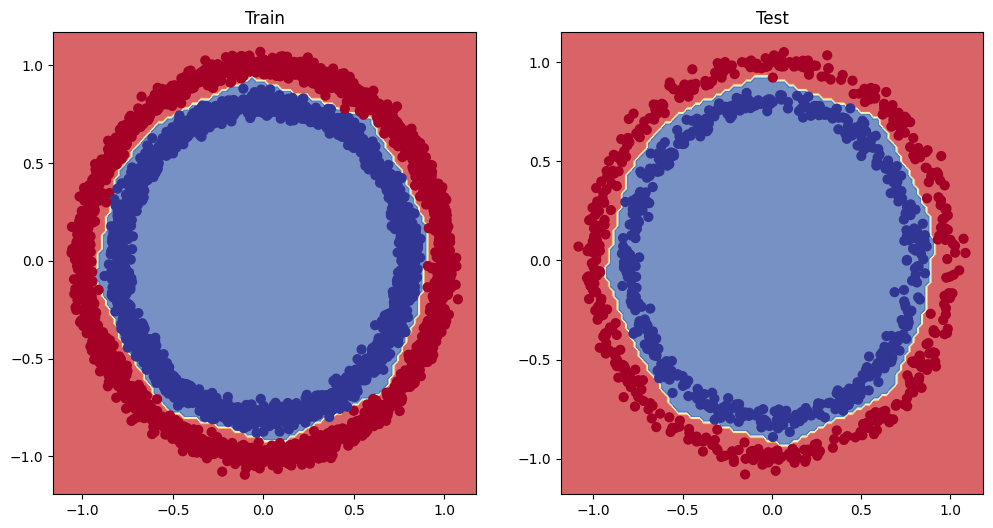

In [1]:
import torch
from torch import nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path

torch.__version__

# Random seed number
RANDOM_SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch is using: {device}")

from sklearn.datasets import make_circles

# Make 10000 samples
n_samples = 5000

# Create Circles
X, y = make_circles(n_samples, noise = 0.03, random_state = RANDOM_SEED)

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Scikit learn has methods to do Train/Test split on data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% test, 80% train
                                                    random_state = 42)

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        # Create layers that handle our shapes
        self.layer_1 = nn.Linear(in_features = 2, out_features = 8) # takes in 2, upscales to 8
        self.layer_2 = nn.Linear(in_features = 8, out_features = 16)
        self.layer_3 = nn.Linear(in_features = 16, out_features = 8)
        self.layer_4 = nn.Linear(in_features = 8, out_features = 1) # takes in 8, outputs 1
        self.relu = nn.ReLU()

    # Forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_4(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))) # x -> layer 1 -> layer 2

# Instantiate to device
model_3 = CircleModelV3().to(device)

# Make predictions
with torch.inference_mode():
    untrained_preds = model_3(X_test.to(device)) # pass test data to model/device

# Loss function (B C E, Binary Cross Entropy)
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in, this is the numerical stable way

# Optimizer
optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

# Calculate accuracy out of 100 examples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item gets the value out as a single item, this also moves it to cpu
    acc = (correct / len(y_pred)) * 100
    return acc

# View first 5 outputs of the forweard pass on the test data
model_3.eval() # Use training mode when making predictions
with torch.inference_mode(): # Use inference mode when making predictions
    y_logits = model_3(X_test.to(device))[:5]

y_pred_probs = torch.sigmoid(y_logits)

##### Find the predicted labels
# We got raw logits, then turned them into pred probs, now we need pred labels
y_preds = torch.round(y_pred_probs) # predicted labels

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_3(X_test.to(device))[:5]))

# Get rid of extra dimension
y_preds.squeeze()

# Seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epoochs
epochs = 5000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building and eval loop
for epoch in range(epochs):
    # Training
    model_3.train()

    # Forward Pass
    y_logits = model_3(X_train).squeeze() # pass raw logits
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calc loss and accuracy
    loss = loss_fn(y_logits, # Because we are using BCEWithLogits, it expects logits as input
                   y_train)
    # If we were writing loss with BCELoss without logits
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # creates pred prob from logits
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # Optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        # Testing forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Testing Calc loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")

# Download helper func from learn pytorch repo if its not downlaoded
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Then import the file
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)





### Replicating Non-Linear Activation Functions

* NN's we give it tools to discover patterns in data and it figures out the patterns on its own
* We do not tell the model what to learn
* * These tools are Linear and Non-Linear Functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

In [ ]:
A

In [ ]:
# Visualize the data - Linear
plt.plot(A)

In [ ]:
plt.plot(torch.sigmoid(A))

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
# Manually create relu
def relu(x: torch.Tensor) -> torch.Tensor:  # Input must be a tensor, and output will be a tensor
    return torch.max(torch.tensor(0), x) # input must be tensor

A, relu(A)

In [ ]:
plt.plot(relu(A))

In [ ]:
# Same for sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

A, sigmoid(A)

In [ ]:
plt.plot(sigmoid(A))

### Building a Multiclass Dataset

* Binary Classification - Cat vs Dog
* Multiclass Classification - Cat vs Dog vs Chicken, Infinite things
* * Uses `torch.softmax` vs `torch.sigmoid` activation function

In [ ]:
# Imports
import torch
import matplotlib.pyplot as plt
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

# Set hyperparameters, dictated by scikit learn imports
# This really looks like the way to self train, you could even use a randomizer
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Create multiclass data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, # give the clusters a little randomness, high difficulty
                            random_state = RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# Plot the data
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

### Building a multi-class classification model

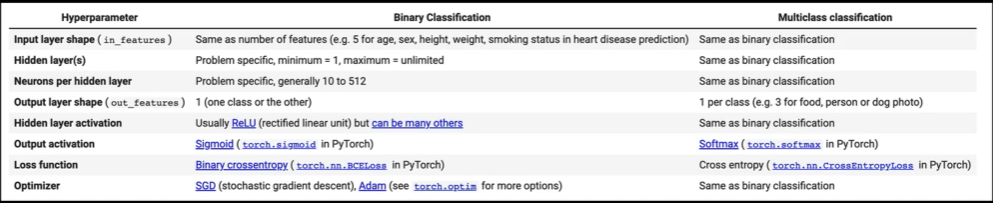

In [ ]:
# Build model - multi-class
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features = 2, output_features = 4, hidden_units = 8).to(device)

model_4

In [ ]:
# Loss and optimizer
# We will use CrossEntropyLoss for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

### Get prediction probabilities for a multi-class PyTorch Model

We need to convert the models output logits to pred prob, to pred labels via activation function

In [ ]:
# Get raw outputs
model_4.eval() # Use training mode when making predictions
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

# Convert logit outputs to pred probabilities
# We got raw logits, then turned them into pred probs, now we need pred labels
# This will be a little different because we are using CrossEntropyLoss and not BCEWithLogitsLoss
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

# Find the predicted labels and get them in the right format for comparison
y_preds = torch.argmax(y_pred_probs, dim = 1)
print(y_preds[:5])

### Logits -> Pred Probs `torch.softmax` -> Pred Labels `torch.argmax`

### Create training loop and testing loop for a multi-class pytorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 100

# Put data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Training Loops
for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_preds)
    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")



In [ ]:
# Download helper func from learn pytorch repo if its not downlaoded
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Then import the file
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### A few more classification metrics

### Evaluating a model is just as important as training a model

* Accuracy - out of 100 samples how many does the model get right
  * `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`
  * Default metric for classification problems, not the best for imbalanced classes
* Precision
  * Arcticle about when to use precision and recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
  * `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`
  * Higher precision leads to less false positives
* Recall
  * `torchmetrics.Recall()` or `sklearn.metrics.recall_Score()`
  * High recall leads to less false negatives
  * There is a precision/recall tradeoff, if you raise one you lower the other and vice versa
* F1-score which combined Precision and Recall
  * `torch.metrics.F1Score()` or `sklearn.metrics.f1_score()`
  * Combination of precision/recall and typically a good metric for classification models
* Confusion Matrix
  * `torchmetrics.ConusionMatrix()`
  * When comparing predictions to truth labels to see where models gets confused. Hard to use with large number of classes.
* Classification Report
  * `sklearn.metrics.classification_report()`
  * Quick and easy to read summary of the performance of a classifier

* https://torchmetrics.readthedocs.io/en/latest
* https://lightning.ai/docs/torchmetrics/stable/


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device) # make sure torchmetrics is on the same device as the model
# calc accuracy
torchmetric_accuracy(y_preds, y_blob_test)